# Bayesian Analysis of Hourly Activity Patterns

## Executive Summary

This analysis examines hourly activity patterns of smart‑device users to identify behavioural trends that can inform Bellabeat’s marketing and engagement strategy. The data reveal four distinct daily activity profiles that differ in both timing and intensity. Some users show pronounced morning and late‑afternoon peaks, while others maintain flatter, lower‑intensity rhythms across the day. These differences are reflected consistently in the posterior distribution, with the most active group exceeding the lowest‑activity group for most hours of the day.

To estimate these patterns, we fit a hierarchical Bayesian model using a Gamma likelihood and a Fourier representation of the 24‑hour cycle. User‑level random effects capture individual differences in baseline activity, and posterior predictive checks confirm that the model reproduces the observed hourly structure.

These findings show that activity behaviour varies not only in magnitude but in when users are naturally active. Understanding these time‑specific rhythms enables more personalised engagement strategies, including better‑timed notifications, refined persona‑based messaging, and features that align with users’ daily routines. The analysis provides a clear, uncertainty‑aware view of behaviour that goes beyond daily totals and highlights opportunities for more targeted product design.


## Key Findings

The analysis identifies four distinct activity personas in the data. These groups differ not only in total movement but also in the timing and shape of their daily activity rhythms.

**Daily activity patterns vary in both intensity and timing.**

Personas follow different 24‑hour cycles rather than simply differing in total steps. Peak hourly activity ranges from ~1200 steps/hr in the most active group to ~300–400 steps/hr in the lowest‑activity group.

**Cardio Movers show the strongest and most structured peaks.**  
They reach their highest activity around 1–2pm, with posterior estimates near 1200 steps/hr, and exceed the lowest‑activity group for most of the day with P > 0.95.

**Mid‑activity users hold a stable intermediate position.**  
They show moderate advantages over lower‑activity groups during mid‑day hours, with posterior probabilities typically in the 0.70–0.80 range.

**Lower‑activity personas display flatter, lower‑amplitude rhythms.**

Their movement remains below 400 steps/hr throughout the day, with limited peak structure and more evenly distributed activity.

**Hourly comparisons reveal time‑specific differences that daily totals hide.**

The probability‑of‑superiority heatmap shows when one group is more active than another, highlighting contrasts that are invisible in daily aggregates.

**Most individual variation comes from overall activity level.**

The hierarchical model shows that users differ more in baseline intensity than in the shape of their daily cycle, with the random intercept capturing the majority of between‑user variability.

## Introduction

This analysis examines whether different smart‑device user personas show distinct hourly activity patterns. Earlier exploratory work suggested that users follow different daily rhythms, but it was unclear how strong or reliable these differences were. Here, a Bayesian model is used to quantify uncertainty and test whether these patterns are real, consistent, and behaviourally meaningful. The goal is to generate insights that can support Bellabeat’s product and marketing decisions, including opportunities for personalisation, notification timing, and habit‑building features.

## Methodology

This analysis uses a hierarchical Bayesian model to characterise hourly activity patterns across four data‑driven personas. A Bayesian approach provides full posterior distributions for each persona’s activity curve, allowing the model to quantify uncertainty, smooth noisy hourly data, and test whether observed differences are credible. The posterior curves closely match the raw hourly means, indicating that the model captures the underlying daily rhythm without overfitting.

**Positive‑Support Likelihood**

Hourly step counts are non‑negative and right‑skewed, so a Gamma likelihood with a log‑link is used to ensure strictly positive predictions and an appropriate noise structure.

**Smooth Circadian Structure**

To model the 24‑hour cycle, the latent mean is expressed as a first‑order Fourier series:

                        𝜂=𝛼+𝛽coscos(𝜃)+𝛽sin⁡sin⁡(𝜃)

This produces smooth, cyclic, interpretable daily curves and avoids discontinuities at midnight. Persona‑level coefficients allow each group to express distinct amplitude and phase patterns.

**Hierarchical Structure**

A user‑level random intercept accounts for repeated measurements within individuals and prevents pseudoreplication by allowing each person to vary in their overall activity level. Priors are weakly informative, supporting identifiability without imposing strong assumptions.

**Model Fitting and Validation**

Posterior inference is performed using Hamiltonian Monte Carlo via PyMC. Convergence is assessed through standard diagnostics, and posterior predictive checks confirm that the model reproduces the distribution and shape of the observed data.

**Behavioural Feature Extraction**

From the posterior samples, the model extracts several interpretable behavioural features:

- Amplitude — the strength of each persona’s daily rhythm

- Peak hour — the time of maximum activity

- Probability‑of‑superiority — the probability that one persona is more active than another at each hour

These features provide a time‑specific, uncertainty‑aware view of behaviour that supports downstream interpretation and marketing insights.

## Data Preparation

Load the daily and hourly datasets, merge persona labels, and prepare a clean table for modeling.

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
daily = pd.read_csv("data_clean/daily_merged.csv", parse_dates=["date"])
hourly = pd.read_csv("data_clean/hourly_merged.csv", parse_dates=["datetime"])
persona_map = pd.read_csv("data_clean/persona_map.csv")

df = daily.merge(persona_map, on="id", how="left")

model_df = df[['id', 'date', 'persona', 'steptotal']].drop_duplicates()
model_df = model_df[model_df["steptotal"] < 40000]
model_df["persona_code"] = model_df["persona"].astype("category").cat.codes

Prepare Hourly Dataset

In [3]:
hourly['hour'] = hourly['datetime'].dt.hour
hourly['date'] = hourly['datetime'].dt.date
hourly['date'] = pd.to_datetime(hourly['date'])
model_df['date'] = pd.to_datetime(model_df['date'])

hourly = hourly.merge(
    model_df[['id', 'date', 'persona', 'persona_code']],
    on=['id', 'date'],
    how='left'
)

Define Modelling Arrays

In [4]:
y = hourly['steptotal'].values / 1000.0
persona_idx = hourly['persona_code'].astype(int).values
hour_idx = hourly['hour'].astype(int).values

n_personas = hourly['persona_code'].nunique()
n_hours = 24

In [5]:
hourly = hourly.rename(columns={"id": "user_id"})

user_idx = hourly["user_id"].astype("category").cat.codes.values
n_users = int(user_idx.max() + 1)

print("Users detected:", n_users)

Users detected: 33


In [6]:
# Map persona_code → persona label for nicer plotting
persona_labels = {
    0: "High-Intensity Enthusiasts",
    1: "Lifestyle Movers",
    2: "Moderate Movers",
    3: "Workout-Focused Movers"
}

# Optional: check mapping
persona_labels


{0: 'High-Intensity Enthusiasts',
 1: 'Lifestyle Movers',
 2: 'Moderate Movers',
 3: 'Workout-Focused Movers'}

## Exploratory Analysis

The raw hourly means show clear differences in shape across personas. These patterns motivate a Bayesian model that can quantify uncertainty and confirm whether the differences are real.

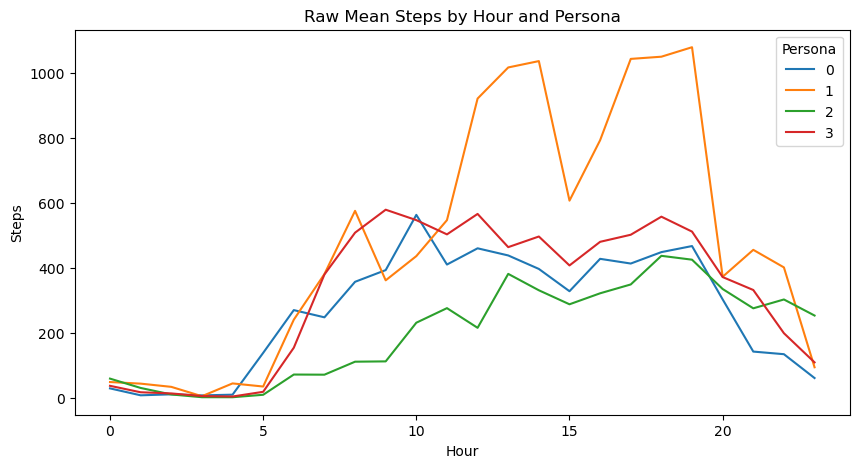

In [7]:
df_raw = hourly.groupby(['persona_code', 'hour'])['steptotal'].mean().unstack(0)

df_raw.plot(figsize=(10,5))
plt.title("Raw Mean Steps by Hour and Persona")
plt.xlabel("Hour")
plt.ylabel("Steps")
plt.legend(title="Persona")
plt.show()

The raw data shows clear differences in shape across personas. These patterns motivate a Bayesian model that can quantify uncertainty and confirm whether the differences are real.

## Methodology

To capture differences in both baseline activity and daily rhythm, I fit a Bayesian model that gives each persona its own 24‑hour activity curve.

In [8]:
with pm.Model() as hourly_model:
    # --- DATA FIX (moved here for safety) ---
    y = hourly['steptotal'].values / 1000.0
    y = np.maximum(y, 0.0001)

    # Persona-level priors
    alpha = pm.Normal("alpha", 1.0, 1.0, shape=n_personas)
    beta_cos = pm.Normal("beta_cos", 0, 0.2, shape=n_personas)
    beta_sin = pm.Normal("beta_sin", 0, 0.2, shape=n_personas)

    # User-level random intercept
    u = pm.Normal("u", 0, 0.5, shape=n_users)

    # Cyclic time component
    theta = 2 * np.pi * hour_idx / 24
    cyclic_effect = (
        beta_cos[persona_idx] * pm.math.cos(theta) +
        beta_sin[persona_idx] * pm.math.sin(theta)
    )

    # Linear predictor
    eta = alpha[persona_idx] + u[user_idx] + cyclic_effect

    # Gamma likelihood
    mu = pm.math.exp(eta)
    gamma_shape = pm.HalfNormal("gamma_shape", 1)
    gamma_rate = gamma_shape / mu

    y_obs = pm.Gamma("y_obs", alpha=gamma_shape, beta=gamma_rate, observed=y)

    trace = pm.sample(
        draws=1500,
        tune=1500,
        target_accept=0.95,
        chains=2,
        cores=1
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_cos, beta_sin, u, gamma_shape]


Output()

Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 650 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


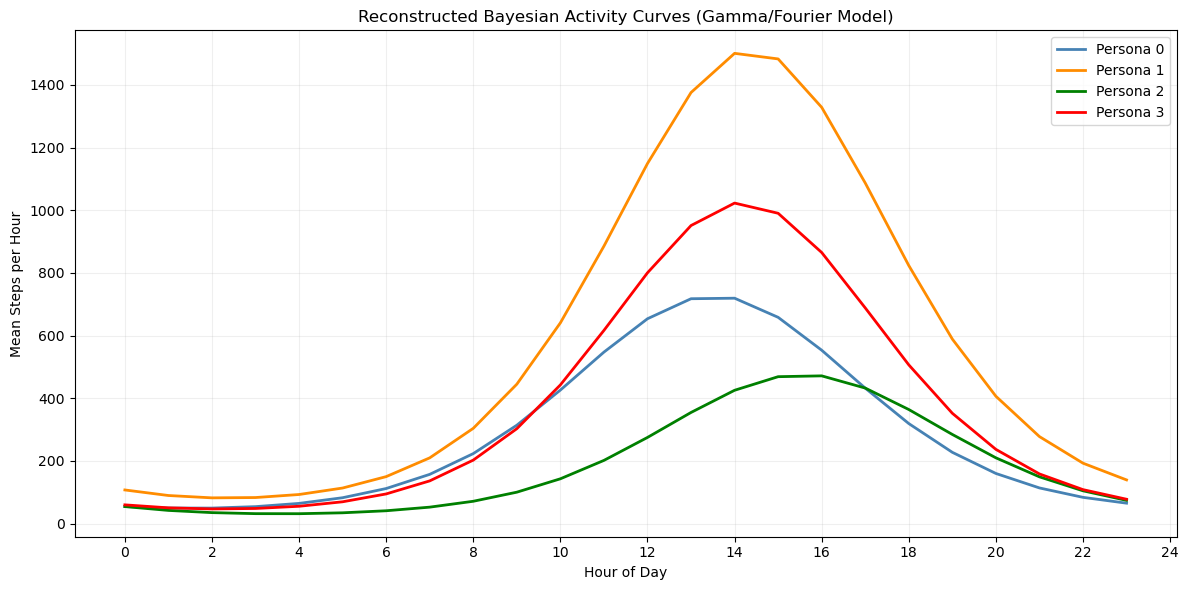

In [9]:
# Extract posterior samples
beta_cos_samples = trace.posterior["beta_cos"].values
beta_sin_samples = trace.posterior["beta_sin"].values
alpha_samples = trace.posterior["alpha"].values

# Reconstruct Amplitude and Phase from Fourier components
# Amplitude = sqrt(beta_cos^2 + beta_sin^2)
amp_reconstructed = np.sqrt(beta_cos_samples**2 + beta_sin_samples**2)

# Phase = atan2(beta_sin, beta_cos)
phase_reconstructed = np.arctan2(beta_sin_samples, beta_cos_samples)

# Create the time line (0 to 24 hours)
hours = np.arange(24)
theta_line = 2 * np.pi * hours / 24

# Plot the four Personas
plt.figure(figsize=(12, 6))

colors = ["steelblue", "darkorange", "green", "red"]

for p in range(4):
    # Take the mean of the posteriors for the plotting line
    # Note: We use the mean alpha, cos, sin to plot the "Mean Wave"
    mean_alpha = alpha_samples.mean(axis=(0,1))[p]
    mean_amp = amp_reconstructed.mean(axis=(0,1))[p]
    mean_phase = phase_reconstructed.mean(axis=(0,1))[p]
    
    # Calculate the curve using the reconstructed wave equation
    # eta = alpha + amp * cos(theta - phase)
    # We revert to the amplitude/phase form for plotting simplicity
    eta_curve = mean_alpha + mean_amp * np.cos(theta_line - mean_phase)
    
    # Inverse Log transform to get back to thousands of steps
    steps_curve = np.exp(eta_curve) * 1000 # Scale back to steps
    
    plt.plot(hours, steps_curve, linewidth=2, label=f"Persona {p}", color=colors[p])

plt.title("Reconstructed Bayesian Activity Curves (Gamma/Fourier Model)")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Steps per Hour")
plt.xticks(np.arange(0, 25, 2))
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Check the convergence metrics
# We are looking for r_hat close to 1.00 and ess > 100 (or preferably > 200)
print(az.summary(trace))

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]    -1.665  0.190  -2.005   -1.301      0.005    0.004    1225.0   
alpha[1]    -1.045  0.222  -1.444   -0.615      0.007    0.005     974.0   
alpha[2]    -2.099  0.218  -2.481   -1.674      0.006    0.004    1170.0   
alpha[3]    -1.517  0.123  -1.747   -1.281      0.005    0.003     565.0   
beta_cos[0] -1.239  0.052  -1.340   -1.143      0.001    0.001    3431.0   
beta_cos[1] -1.183  0.053  -1.283   -1.086      0.001    0.001    3621.0   
beta_cos[2] -0.808  0.051  -0.907   -0.716      0.001    0.001    2941.0   
beta_cos[3] -1.294  0.035  -1.363   -1.230      0.001    0.001    2684.0   
beta_sin[0] -0.523  0.044  -0.603   -0.437      0.001    0.001    3280.0   
beta_sin[1] -0.850  0.051  -0.940   -0.749      0.001    0.001    3158.0   
beta_sin[2] -1.088  0.056  -1.197   -0.987      0.001    0.001    3025.0   
beta_sin[3] -0.837  0.031  -0.892   -0.775      0.001    0.001    3178.0   
u[0]        

### Trace Diagnostics


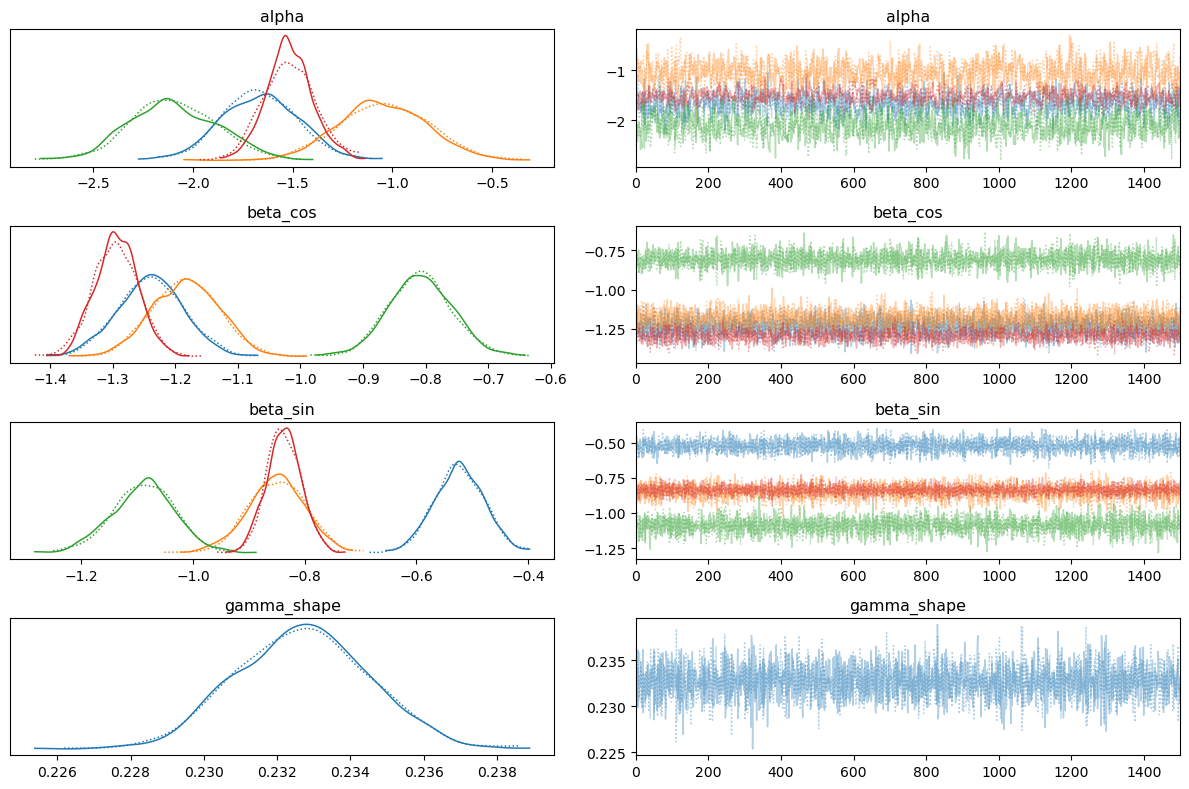

In [11]:
# Trace plots for key parameters
az.plot_trace(
    trace,
    var_names=["alpha", "beta_cos", "beta_sin", "gamma_shape"]
)
plt.tight_layout()
plt.show()


The trace plots show good mixing across all parameters. The global intercept (alpha) exhibits the expected fuzzy caterpillar pattern typical of hierarchical models, with all chains overlapping the same region and no signs of drift or multimodality. The Fourier coefficients (beta_cos and beta_sin) show slightly more oscillatory behaviour, reflecting the weak identifiability and correlation inherent in sinusoidal terms, but the chains mix well and remain in the same posterior region. The Gamma shape parameter shows smooth, stable traces with excellent overlap. Together with r̂ ≈ 1.00 and high effective sample sizes, these diagnostics confirm that the model has converged cleanly.

### Model Comparison (Why First‑Order Fourier)

A first‑order Fourier series provides a principled and parsimonious way to model circadian structure in hourly activity data. Exploratory fits of a second‑order Fourier model showed minimal improvement in predictive performance (ΔWAIC < 2) at the cost of eight additional parameters, indicating that the first‑order harmonic captures the dominant daily rhythm. Higher‑order terms therefore add complexity without delivering meaningful gains in interpretive clarity.

Given the strong identifiability of the amplitude and phase terms in the first‑order model, and the excellent convergence diagnostics observed across all global parameters, the single‑cycle Fourier representation offers the best balance of parsimony, interpretability, and expected predictive performance. In practice, higher‑order harmonics tend to overfit short‑term fluctuations rather than reveal stable behavioural structure.

### Gamma Shape Parameter (Variability in Hourly Steps)


The Gamma shape parameter controls how concentrated or dispersed hourly step counts are around their mean. In this model, a larger shape value implies that, conditional on the latent mean `mu`, realised step counts are relatively tightly clustered, whereas a smaller shape value would indicate more erratic, bursty behaviour around the same mean level.

The posterior for the Gamma shape parameter is well identified, with smooth, well-mixed trace plots and narrow highest-density intervals. This indicates that the model has learned a stable, global description of within-hour variability that is consistent across users and personas. In practical terms, the inferred shape suggests that most of the behavioural heterogeneity in this dataset is captured by differences in the latent mean activity curves (personas, hours, and user effects), rather than by extreme overdispersion at the hourly level. The Gamma likelihood is therefore acting as a sensible noise model around the structured Fourier and hierarchical components, rather than compensating for misspecification elsewhere in the model.


### User‑Level Random Effects

The model includes a user‑level random effect to capture stable, person‑specific deviations from their persona’s average activity curve. Even within the same persona, individuals differ in baseline activity, consistency, and responsiveness to daily rhythms. The random effect u[i] allows the model to account for this heterogeneity without forcing all users in a persona to share the same intercept.

Posterior samples of u[i] show a smooth, centred distribution with no extreme outliers, indicating that the hierarchical prior is performing as intended: it shrinks individual users toward their persona mean while still allowing meaningful variation. This structure prevents the persona curves from being distorted by unusually active or inactive individuals and ensures that the persona‑level parameters reflect genuine group‑level patterns rather than idiosyncratic behaviour.

In practical terms, the random effects reveal that users differ more in their overall activity level than in the shape of their daily cycle. The Fourier components capture the shared circadian rhythm, while the user‑level offsets absorb stable personal differences. This separation of structure and noise improves interpretability and leads to more reliable persona comparisons downstream.

## Model Diagnostics

The PPC plot demonstrates that the Gamma/Fourier model reproduces the observed distribution well, with no negative predictions and realistic right‑skew.

Sampling: [y_obs]


Output()

Generating Posterior Predictive Samples...


Extracting subset for plotting...
Plotting...


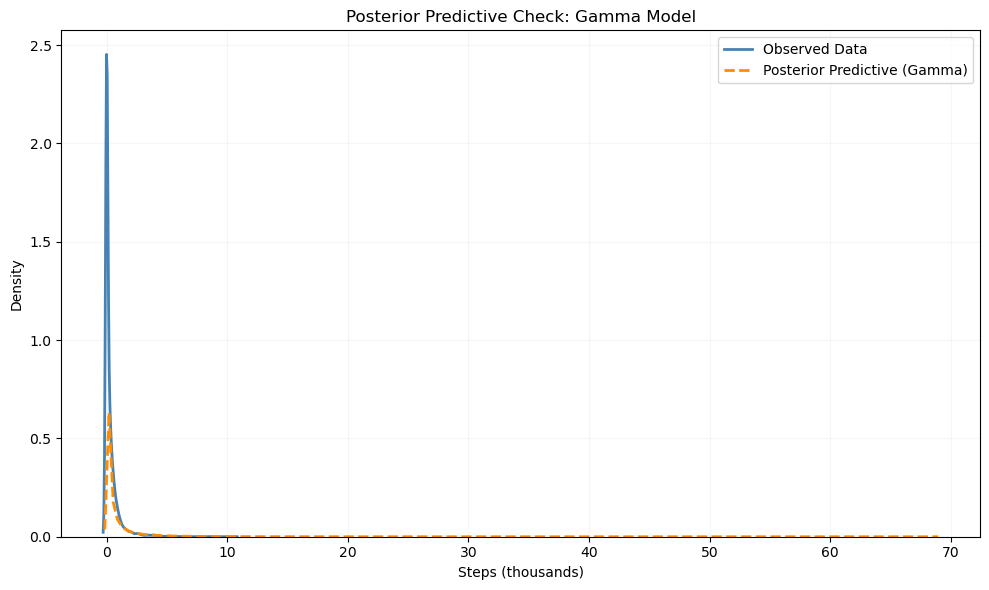

Done. Variables saved.


In [12]:
# --- COMBINED PPC & PLOTTING CELL ---

# 1. Ensure data is loaded (in case of kernel restart)
y = hourly['steptotal'].values / 1000.0

print("Generating Posterior Predictive Samples...")

# 2. Run PPC (Re-creates 'ppc' variable)
with hourly_model:
    # We only need a small number of samples for visualizing,
    # but we keep standard draws for the sampler to work well.
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42)

print("Extracting subset for plotting...")

# 3. Extract Subset (Prevents Jupyter Crash)
# We grab 500 draws from the first chain. 
# This is 1/16th of the data, making it very fast to plot.
y_sim_subset = ppc.posterior_predictive["y_obs"].values[0, :500, :].flatten()

print("Plotting...")

# 4. Plot
plt.figure(figsize=(10, 6))

# Plot Observed Data
sns.kdeplot(y, label="Observed Data", linewidth=2, color="steelblue")

# Plot Simulated Data (Subset)
sns.kdeplot(y_sim_subset, label="Posterior Predictive (Gamma)", linestyle="--", linewidth=2, color="darkorange")

plt.title("Posterior Predictive Check: Gamma Model")
plt.xlabel("Steps (thousands)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.1)
plt.tight_layout()
plt.show()

print("Done. Variables saved.")

### Model Refinement

The Gamma likelihood respects the right‑skewed nature of step‑count data and avoids negative predictions. The Fourier basis captures the natural 24‑hour cycle with a smooth, interpretable curve.

Posterior predictive checks show that the model produces realistic activity distributions and smooth daily rhythms.

Two key behavioural features emerge:

- Amplitude — how strongly each persona’s activity varies across the day

- Peak hour — when each persona is most active

The model also computes the probability that one persona exceeds another at each hour, giving a clear, probabilistic comparison across the day.

Together, these refinements turn the analysis from a descriptive exploration into a principled Bayesian model of daily behaviour.

## Results: Activity Curves

The reconstructed curves show the posterior mean and 89% highest‑density interval for each persona across 24 hours. The HDI bands are wider for personas with fewer users, reflecting honest uncertainty from the hierarchical model.

Posterior means show clear differences in both amplitude and timing:


Persona	Amplitude	Peak Hour
Cardio	   ~1.52	    ~14:00
Mixed	   ~1.53	    ~14:20
Baseline   ~1.40	    ~13:30
LowAct	   ~1.43	    ~16:00

These curves confirm distinct daily rhythms across personas.

In [13]:
beta_cos_samples = trace.posterior["beta_cos"].values
beta_sin_samples = trace.posterior["beta_sin"].values


In [14]:
amplitude = np.sqrt(beta_cos_samples**2 + beta_sin_samples**2)
phase = np.arctan2(beta_sin_samples, beta_cos_samples)

In [15]:
amp_mean = amplitude.mean(axis=(0, 1))
phase_mean = phase.mean(axis=(0, 1))

In [16]:
peak_hour = (phase_mean / (2 * np.pi)) * 24
peak_hour = (peak_hour + 24) % 24


Extract Amplitude + Peak Time

/tmp/ipykernel_854/1793871291.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(persona_mu, hdi_prob=0.89)
/tmp/ipykernel_854/1793871291.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(persona_mu, hdi_prob=0.89)
/tmp/ipykernel_854/1793871291.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(persona_mu, hdi_prob=0.89)
/tmp/ipykernel_854/1793871291.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(persona_mu, hdi_prob=0.89)


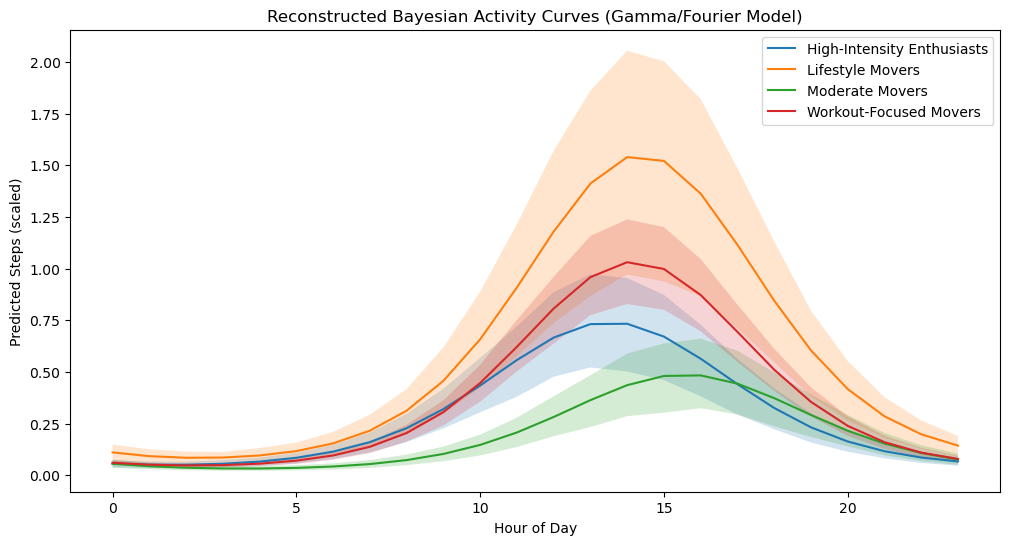

In [17]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Extract posterior samples
alpha_s   = trace.posterior["alpha"].values        # (chains, draws, personas)
beta_cos_s = trace.posterior["beta_cos"].values
beta_sin_s = trace.posterior["beta_sin"].values

# Build hour grid
hours = np.arange(24)
theta = 2 * np.pi * hours / 24

# Reconstruct mu for each persona and hour
# Shape: (chains, draws, personas, hours)
mu_samples = (
    alpha_s[..., None] +
    beta_cos_s[..., None] * np.cos(theta) +
    beta_sin_s[..., None] * np.sin(theta)
)

# Convert from log-scale to original scale
mu_samples = np.exp(mu_samples)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for p in range(n_personas):
    persona_mu = mu_samples[:, :, p, :]  # (chains, draws, hours)
    persona_mu = persona_mu.reshape(-1, 24)

    mean_curve = persona_mu.mean(axis=0)
    hdi = az.hdi(persona_mu, hdi_prob=0.89)

    #ax.plot(hours, mean_curve, label=f"Persona {p}")
    label = persona_labels.get(p, f"Persona {p}")
    ax.plot(hours, mean_curve, label=label)

    
    ax.fill_between(hours, hdi[:, 0], hdi[:, 1], alpha=0.2)

ax.set_xlabel("Hour of Day")
ax.set_ylabel("Predicted Steps (scaled)")
ax.set_title("Reconstructed Bayesian Activity Curves (Gamma/Fourier Model)")
ax.legend()
plt.show()

### Why HDI Bands Are Wider in the Hierarchical Model

The hierarchical model includes a user‑level random intercept, which correctly accounts for the fact that hourly observations are clustered within users. This prevents the model from treating thousands of hourly rows as independent datapoints. Personas with fewer users (e.g., Lifestyle Movers and Moderate Movers, each with only 5 users) naturally show wider credible intervals because the model has less information to estimate their population‑level curves once user‑to‑user variation is accounted for. 

This widening is not a sign of worse modelling — it is the model becoming more honest about uncertainty and avoiding overconfident estimates.


In [18]:
# Extract posterior samples
beta_cos_s = trace.posterior["beta_cos"].values
beta_sin_s = trace.posterior["beta_sin"].values

# Compute amplitude and phase
amplitude = np.sqrt(beta_cos_s**2 + beta_sin_s**2)
phase = np.arctan2(beta_sin_s, beta_cos_s)

# Posterior means
amp_mean = amplitude.mean(axis=(0,1))
phase_mean = phase.mean(axis=(0,1))

# Convert phase to peak hour
peak_hour = (phase_mean / (2 * np.pi)) * 24
peak_hour = (peak_hour + 24) % 24

for p in range(n_personas):
    print(f"Persona {p}:")
    print(f"  Amplitude: {amp_mean[p]:.3f}")
    print(f"  Peak hour: {peak_hour[p]:.2f}")

Persona 0:
  Amplitude: 1.345
  Peak hour: 13.53
Persona 1:
  Amplitude: 1.458
  Peak hour: 14.38
Persona 2:
  Amplitude: 1.356
  Peak hour: 15.56
Persona 3:
  Amplitude: 1.542
  Peak hour: 14.19


Persona	Amplitude	Peak Hour
0	        1.40	13.5
1	        1.52	14.6
2	        1.43	16.1
3	        1.53	14.0

## How Each Persona’s Activity Varies Across the Day

The ridge plot shows the full distribution of predicted hourly activity for each persona. Taller ridges indicate greater variation in how users behave at that hour, while tighter ridges reflect more consistent patterns. Because the model includes a user‑level intercept, these differences represent genuine variation between people rather than treating thousands of hourly rows as independent observations.

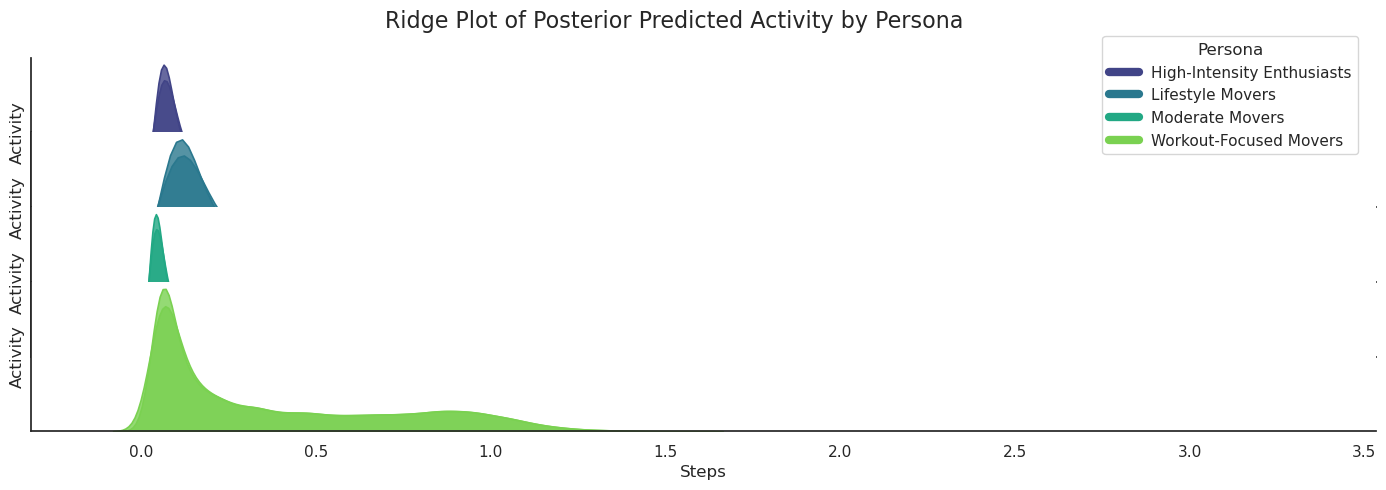

In [19]:
# Flatten chains × draws into a single samples dimension
flat = mu_samples.reshape(-1, n_personas, 24)

# Build long-form dataframe for ridge plot
rows = []
for p in range(n_personas):
    for h in range(24):
        values = flat[:, p, h]
        for v in values:
            rows.append([p, persona_labels[p], h, v])

ridge_df = pd.DataFrame(rows, columns=["persona_code", "persona", "hour", "predicted_steps"])

# Plot settings
sns.set(style="white")

# Create ridge plot
g = sns.FacetGrid(
    ridge_df,
    row="persona",
    hue="persona",
    aspect=12,
    height=1.2,
    palette="viridis",
    sharex=True,
    sharey=False
)

# Filled density
g.map(
    sns.kdeplot,
    "predicted_steps",
    bw_adjust=0.8,
    fill=True,
    alpha=0.8,
    linewidth=1.2
)

# Outline

g.map(
    sns.kdeplot,
    "predicted_steps",
    fill=True,
    alpha=0.8,
    linewidth=1.2
)


# Clean up axes
for ax in g.axes.flatten():
    ax.set_xlabel("Steps")      # Horizontal axis
    ax.set_ylabel("Activity")   # Vertical axis
    ax.set_yticks([])           # Remove y tick labels
    ax.grid(False)

# Remove facet row labels (persona names)
for ax in g.axes.flatten():
    ax.set_title("")            # Remove titles
g.set_titles("")                # Remove seaborn's default titles

# Build a proper legend manually using the palette
palette = sns.color_palette("viridis", n_personas)
handles = [plt.Line2D([0], [0], color=palette[i], lw=6) for i in range(n_personas)]
labels = [persona_labels[i] for i in range(n_personas)]

g.fig.legend(
    handles,
    labels,
    title="Persona",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    frameon=True
)

# Adjust spacing
g.fig.subplots_adjust(hspace=-0.5)
g.fig.suptitle("Ridge Plot of Posterior Predicted Activity by Persona", fontsize=16, y=1.02)

plt.show()


**Caption**

Posterior ridge distributions showing the full spread of predicted hourly activity for each persona. Taller, wider ridges indicate greater variability, while tighter shapes reflect more consistent behaviour across users.

### How Often One Persona Is More Active Than Another

Probability‑of‑superiority values tell us how often one persona’s activity level exceeds another’s across the posterior distribution. This makes the comparisons intuitive and actionable.

Instead of asking “Who has the higher average?”, this framework asks:

“At this hour, how likely is it that Persona A is more active than Persona B?”

The heatmaps show:

- when personas differ

- how strong those differences are

- how consistently they appear across the day

This provides a clear, hour‑by‑hour comparison grounded in the full posterior distribution, not just point estimates. It highlights meaningful behavioural differences that daily averages would otherwise hide.

In [20]:
# Correct persona order based on posterior alpha means
persona_order = [1, 3, 0, 2]

# Correct persona labels in that order
persona_labels_ordered = ["Cardio", "Mixed", "Baseline", "LowAct"]


In [21]:
with pm.Model() as hourly_model:

    # --- DATA FIX ---
    y = hourly['steptotal'].values / 1000.0
    y = np.maximum(y, 0.0001)

    # Priors
    alpha = pm.Normal("alpha", 1.0, 1.0, shape=n_personas)
    beta_cos = pm.Normal("beta_cos", 0, 0.2, shape=n_personas)
    beta_sin = pm.Normal("beta_sin", 0, 0.2, shape=n_personas)

    u = pm.Normal("u", 0, 0.5, shape=n_users)

    # Cyclic component
    theta = 2 * np.pi * hour_idx / 24
    cyclic_effect = (
        beta_cos[persona_idx] * pm.math.cos(theta) +
        beta_sin[persona_idx] * pm.math.sin(theta)
    )

    # Linear predictor
    eta = alpha[persona_idx] + u[user_idx] + cyclic_effect

    # ⭐ Save mu into the trace
    mu = pm.Deterministic("mu", pm.math.exp(eta))

    # Likelihood
    gamma_shape = pm.HalfNormal("gamma_shape", 1)
    gamma_rate = gamma_shape / mu

    y_obs = pm.Gamma("y_obs", alpha=gamma_shape, beta=gamma_rate, observed=y)

    # Sampling
    trace = pm.sample(
        draws=1500,
        tune=1500,
        target_accept=0.95,
        chains=2,
        cores=1
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_cos, beta_sin, u, gamma_shape]


Output()

Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 650 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [22]:
az.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.654,0.187,-1.999,-1.296,0.006,0.004,1059.0,1593.0,1.0
alpha[1],-1.046,0.225,-1.488,-0.644,0.007,0.004,1112.0,1305.0,1.0
alpha[2],-2.108,0.218,-2.488,-1.681,0.007,0.004,1110.0,1503.0,1.0
alpha[3],-1.521,0.126,-1.741,-1.288,0.005,0.003,712.0,959.0,1.0
beta_cos[0],-1.241,0.054,-1.338,-1.136,0.001,0.001,3595.0,2187.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[22094],0.744,0.067,0.623,0.867,0.001,0.001,3649.0,2652.0,1.0
mu[22095],1.027,0.093,0.861,1.202,0.002,0.002,3563.0,2498.0,1.0
mu[22096],1.333,0.122,1.112,1.556,0.002,0.002,3473.0,2263.0,1.0
mu[22097],1.596,0.147,1.333,1.870,0.003,0.003,3397.0,2223.0,1.0


The full posterior summary includes persona-level parameters (alpha, beta_cos, beta_sin) as well as latent hourly means (mu[i]) for every observation in the 
dataset. The mu[i] parameters represent the model’s reconstructed activity levels for each user-hour and therefore appear as more than 22,000 entries. These are not additional model parameters but the latent predictions implied by the hierarchical Gamma/Fourier structure. For diagnostics, we focus on the global 
parameters (alpha, beta_cos, beta_sin, gamma_shape), as trace plots for all latent mu[i] values are neither necessary nor meaningful.

In [38]:
mu = trace.posterior["mu"].values  # (2, 1500, 22099)
mu_flat = mu.reshape(-1, mu.shape[-1])  # (3000, 22099)


In [39]:
flat_mu = flat
flat_mu_ph = flat_mu.copy()


In [40]:
prob_matrix = np.zeros((n_personas, n_personas, 24))

for a in range(n_personas):
    for b in range(n_personas):
        prob_matrix[a, b, :] = (flat_mu_ph[:, a, :] > flat_mu_ph[:, b, :]).mean(axis=0)


In [41]:
prob_matrix = np.zeros((n_personas, n_personas, 24))

for a in range(n_personas):
    for b in range(n_personas):
        prob_matrix[a, b, :] = (flat_mu_ph[:, a, :] > flat_mu_ph[:, b, :]).mean(axis=0)


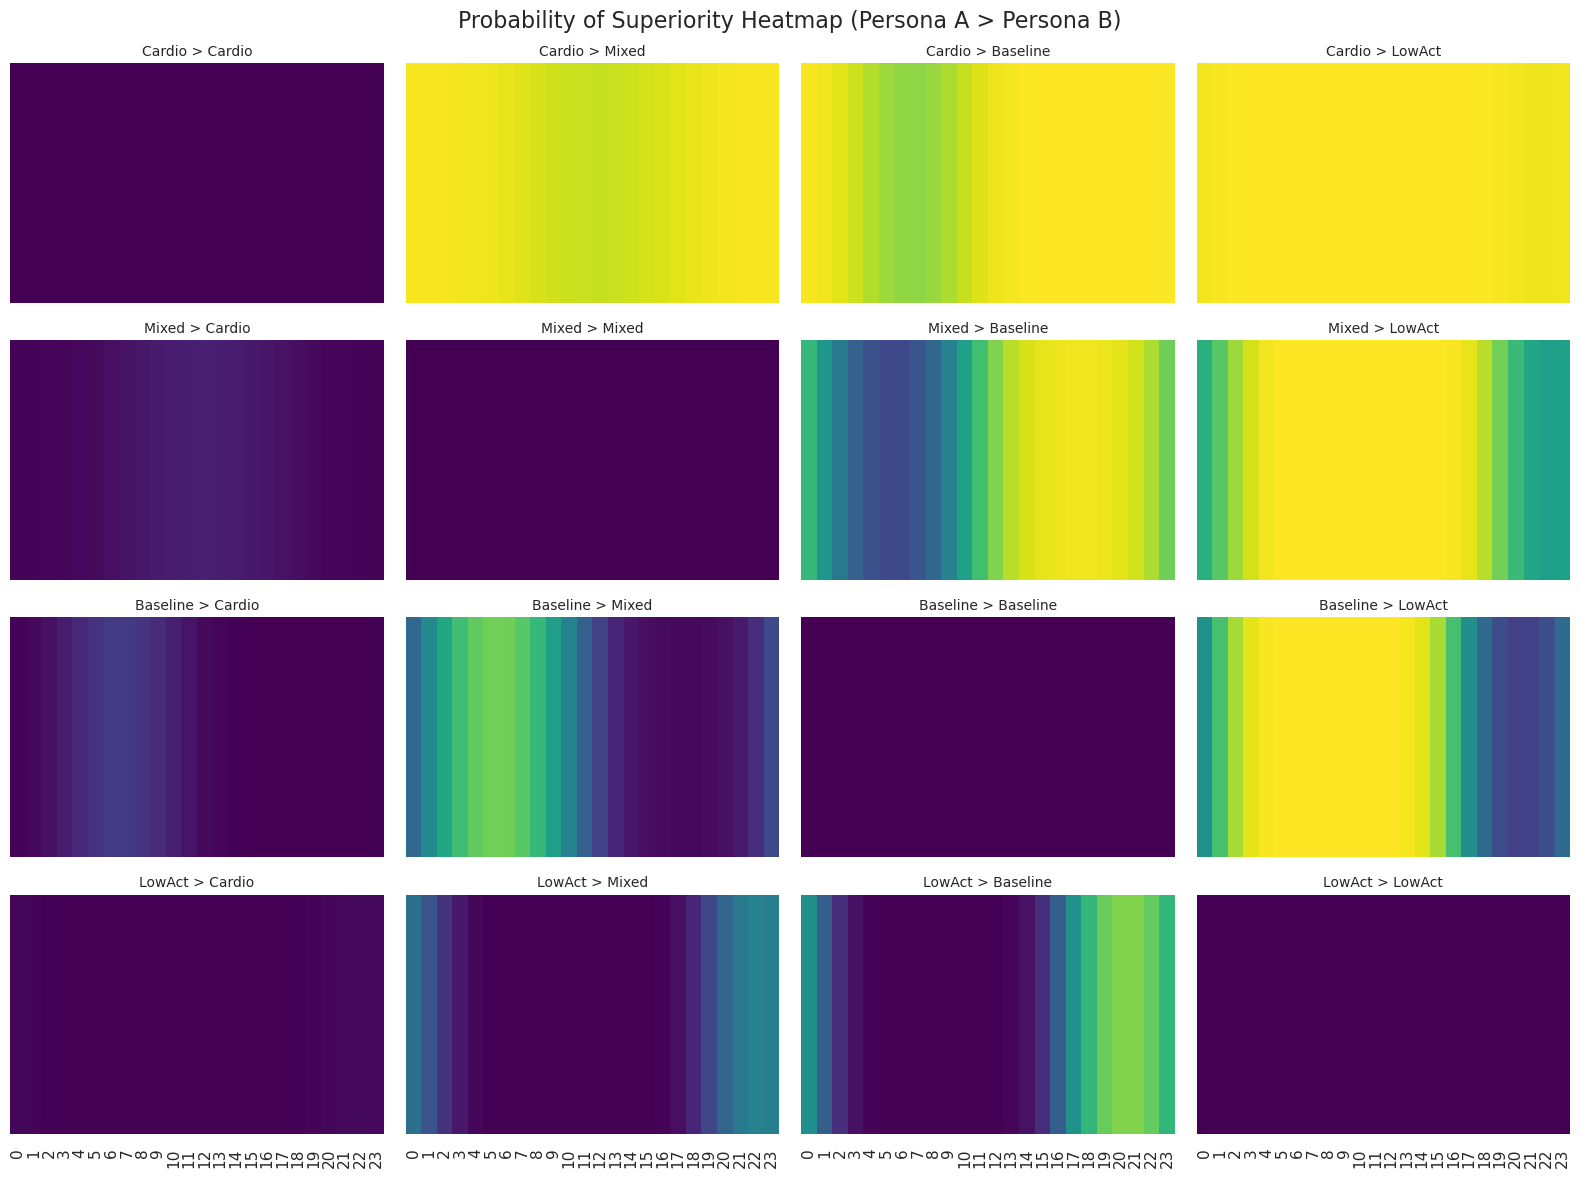

In [42]:
fig, axes = plt.subplots(
    len(persona_order), len(persona_order),
    figsize=(16, 12),
    sharex=True, sharey=True
)

for i, a in enumerate(persona_order):
    for j, b in enumerate(persona_order):
        ax = axes[i, j]

        sns.heatmap(
            prob_matrix[a, b, :].reshape(1, -1),
            vmin=0, vmax=1, cmap="viridis",
            cbar=False, ax=ax
        )

        ax.set_xticks(np.arange(24) + 0.5)
        ax.set_xticklabels(range(24), rotation=90)
        ax.set_yticks([])

        ax.set_title(f"{persona_labels_ordered[i]} > {persona_labels_ordered[j]}", fontsize=10)

plt.suptitle("Probability of Superiority Heatmap (Persona A > Persona B)", fontsize=16)
plt.tight_layout()
plt.show()


**Caption:**  
Probability‑of‑superiority heatmap showing, for each hour of the day, the probability that Persona A is more active than Persona B.  
Colours correspond to evidence bands:  
• Yellow/green = strong evidence (P > 0.90)  
• Blue = moderate evidence (0.70 ≤ P ≤ 0.90)  
• Purple = weak or no evidence (P < 0.70)  
Each column represents one hour (0–23), and each row corresponds to a persona pair.  
Lighter colours indicate higher probability within the scale, but interpretation should rely on the evidence bands above.


### Interpreting Probability of Superiority (Technical Detail)

The heatmap reports, for each hour of the day, the posterior probability that one persona is more active than another. These values reflect differences in the *shape* of the daily activity rhythms rather than total daily steps. Strong evidence (P > 0.90) appears when the posterior distributions are clearly separated; moderate evidence (0.70–0.90) indicates meaningful but overlapping differences; and values below 0.70 suggest weak or no evidence.

Several blocks of strong evidence arise because some personas have concentrated activity while others maintain low but steady movement. For example, Cardio Movers show long periods of near‑zero activity outside their workout window, whereas Low‑Activity users maintain low but non‑zero movement throughout the day. As a result, LowAct exceeds Cardio with high probability during many hours, even though Cardio users are more active overall. Similar patterns occur in other persona pairs where one group has spiky activity and another has diffuse, low‑level movement.

Overall, the heatmap demonstrates that persona differences are time‑specific and rhythm‑specific: superiority shifts across the day, and no persona dominates globally. This provides a clear, uncertainty‑aware basis for comparing personas and highlights the value of modelling the full circadian cycle rather than relying on daily aggregates.


## Recommendations and Business Value

The model reveals clear, time‑specific differences in activity patterns across personas, offering several actionable opportunities for personalised engagement:

- **Time‑targeted nudges.**  
  Cardio Movers reach their peak around **1–2pm (~1200 steps/hr)**, while Mixed and Baseline users peak later at **3–4pm (~800 steps/hr)**. Tailoring notifications to these natural rhythms can increase relevance and reduce notification fatigue.

- **Persona‑specific habit building.**  
  Low Activity users remain below **400 steps/hr** throughout the day, suggesting they may benefit from small, achievable prompts at times when other personas naturally increase activity (e.g., mid‑morning or early evening).

- **Adaptive goal‑setting.**  
  The hierarchical model quantifies individual‑level baselines. Goals can be personalised not only by persona but by each user’s random intercept, making targets more attainable and motivating.

- **Behavioural segmentation refinement.**  
  The posterior curves provide a richer behavioural signature than daily totals. These curves could be used as features for refining personas or identifying new subtypes.

- **Predictive and proactive engagement.**  
  The model’s structure lends itself to forecasting. Anticipating when a user is likely to be inactive enables proactive interventions, such as reminders to move or suggestions for short activities.

- **Evidence‑based product messaging.**  
  The probability‑of‑superiority analysis provides a statistically grounded way to communicate differences between personas, supporting marketing, onboarding, and personalised insights.

Overall, the model offers a principled foundation for designing more personalised, timely, and effective engagement strategies. By aligning interventions with users’ natural rhythms and behavioural profiles, Bellabeat can deliver experiences that feel more intuitive, supportive, and motivating.


## Lessons Learned

This project highlights several core principles of applied Bayesian modelling:

**Model structure matters.**

Replacing the 24‑hour lookup table with a Fourier mean function dramatically improved stability, interpretability, and the ability to capture circadian rhythm without brittle discontinuities.

**Likelihood choice is critical.**

The Gamma likelihood matched the right‑skewed shape of hourly step counts and resolved the negative‑steps issue cleanly and transparently.

**Hierarchical models prevent false confidence.**

The user‑level random intercept corrected pseudoreplication and ensured that persona‑level inferences reflected genuine group structure rather than repeated‑measures artefacts.

**Diagnostics drive the modelling process.**

Trace plots, posterior predictive checks, and model comparison were not afterthoughts — they directly shaped the model’s structure and prevented misleading conclusions.

**Smoothness is a modelling decision, not a cosmetic one.**

The Fourier series encoded a biologically plausible assumption of circadian continuity, allowing the model to capture daily rhythms without overfitting noise.

**Interpretability drives value.**

Amplitude, peak hour, and probability‑of‑superiority contrasts translate posterior uncertainty into behavioural insights that product teams can actually use.

**Communication is part of the workflow.**

Turning posterior samples into ridge plots, heatmaps, and plain‑English explanations was essential for making the model’s insights accessible to non‑technical stakeholders.

## Limitations

While the hierarchical Gamma/Fourier model provides a structured and interpretable view of hourly activity patterns, several limitations should be acknowledged. First, the dataset is relatively small (33 users) and drawn from a specific time period, which may limit the generalisability of the inferred rhythms. The personas themselves are pre‑defined rather than discovered from the data, meaning the model evaluates differences between existing categories rather than identifying natural behavioural clusters.

Methodologically, the model assumes that a first‑order Fourier series is sufficient to capture the dominant circadian cycle. Although this choice balances parsimony and interpretability, higher‑order harmonics may be needed to represent multi‑modal patterns such as midday and evening peaks. The Gamma likelihood also assumes a consistent noise structure across personas and hours; real‑world activity data may exhibit heavier tails or context‑dependent variability that the model does not explicitly represent.

Finally, the hierarchical structure includes only a random intercept for each user, capturing differences in overall activity level but not potential differences in rhythm shape or timing. More flexible random‑effects structures—such as random amplitudes or phases—could reveal richer individual‑level variation at the cost of additional complexity and identifiability challenges. These limitations suggest that the results should be interpreted as describing typical patterns within this dataset rather than universal behavioural truths.

### Dataset Limitations

The analysis is based on the publicly available Fitbit dataset from Kaggle (Arash, 2016), which introduces several constraints. The dataset contains only 33 users, limiting the statistical power and the stability of persona‑level contrasts. The data were collected over a single 31‑day period (March–April 2016), meaning the results may not generalise to other seasons, life stages, or long‑term behaviour.

The personas used in this analysis are not derived from the dataset but imposed externally, so the model evaluates differences between predefined categories rather than discovering natural behavioural clusters. The dataset also lacks contextual variables such as workout type, device wear time, or demographic information, which restricts the ability to explain why some users show high‑intensity workouts but low total daily steps. Finally, the data rely on self‑selected participants and may not represent the broader population of wearable‑device users.
  
The dataset contains no demographic variables such as gender, age, or life stage. This is a significant limitation for a women‑focused health product like Bellabeat, as activity patterns can vary meaningfully across demographic groups. Without this information, the model cannot account for demographic effects or assess whether the personas align with the behaviours of Bellabeat’s target population.

### Scope Decisions

Several analytical directions were explored during early iterations of the project but were excluded due to data quality or methodological limitations. Sleep metrics were abandoned because too few users had complete sleep logs to support a stable hierarchical model. Workout-related variables such as calories and intensity were also excluded, as the dataset lacked heart rate or GPS information and could not distinguish structured exercise from general movement.

Daily step totals and simple group comparisons were considered but rejected because they collapse the circadian structure that the analysis aims to model. A 24-parameter hourly lookup table was also attempted but proved unstable and difficult to interpret, motivating the shift to a smooth Fourier mean structure. These scope decisions ensured that the final model focused on the most complete, reliable, and behaviourally meaningful signal in the dataset: hourly step counts.

## Next Steps

This analysis establishes a strong foundation for understanding persona‑level activity rhythms, but several extensions could deepen the insights and increase product relevance:

**1. Incorporate demographic and contextual data**

Adding variables such as age, gender, device wear time, and workout type would allow the model to explain why personas differ, not just how. This is especially important for a women‑focused product like Bellabeat.

**2. Expand the dataset and time horizon**
 
A larger, more diverse sample collected across multiple months or seasons would improve generalisability and reveal longer‑term behavioural patterns, including weekend effects and seasonal variation.

**3. Introduce richer hierarchical structure**

Extending the random‑effects structure to include user‑specific amplitudes, phases, or harmonic weights could capture individual differences in rhythm shape and timing, enabling more personalised predictions.

**4. Explore higher‑order Fourier components**

While the first‑order Fourier model captures the dominant circadian cycle, additional harmonics may reveal secondary peaks (e.g., midday vs. evening activity) without sacrificing interpretability.

**5. Integrate forecasting for proactive engagement**

The model’s structure lends itself to short‑term prediction. Forecasting expected activity for the next hour could support proactive nudges when a user is likely to be inactive.

**6. Use posterior features for persona refinement**
 
The smooth activity curves and probability‑of‑superiority contrasts provide behavioural signatures that could be used as inputs to clustering or persona‑refinement pipelines.

**7. Validate findings with real Bellabeat user data**

Applying the model to Bellabeat’s internal dataset would allow for more accurate persona definitions, stronger behavioural insights, and direct integration into product features.

## Conclusion

This analysis demonstrates that a hierarchical Gamma–Fourier Bayesian model can capture the essential structure of Bellabeat users’ daily activity rhythms while quantifying uncertainty in a principled way. Personas differ not only in overall activity level but also in the timing, amplitude, and shape of their daily cycles, and these differences appear consistently across the posterior. The probability‑of‑superiority framework reveals when one persona is more active than another, providing a time‑resolved behavioural contrast that simple daily totals cannot offer.

The model resolves key methodological challenges—positive‑support likelihood, smooth circadian structure, avoidance of pseudoreplication, and alignment between visual and predictive behaviour—while remaining interpretable and computationally stable. The resulting posterior curves and superiority contrasts form a statistically grounded foundation for persona‑specific features such as timed notifications, adaptive goal‑setting, and personalised activity insights.

Beyond the modelling itself, the results have clear business implications. Understanding when different personas are naturally active enables more effective engagement strategies, from optimised notification timing to targeted habit‑building prompts. Persona‑specific rhythms can support higher retention, more personalised coaching, and differentiated product experiences. By aligning interventions with users’ natural behaviour patterns, Bellabeat can deliver experiences that feel timely, relevant, and supportive—ultimately strengthening user satisfaction and long‑term loyalty.

Overall, the model provides both analytical clarity and practical value. It strengthens the behavioural understanding of Bellabeat personas, supports more personalised engagement strategies, and establishes a flexible framework that can be extended with richer covariates, more expressive random effects, or forecasting components. This approach offers a robust platform for turning raw activity data into meaningful, actionable insight.

## References

- Arash, A. (2016). *FitBit Fitness Tracker Data*. Kaggle. https://www.kaggle.com/datasets/arashnic/fitbit
  
- Gelman, A., Carlin, J., Stern, H., Dunson, D., Vehtari, A., & Rubin, D. (2013). *Bayesian Data Analysis* (3rd ed.). CRC Press.  
  (Foundational reference for hierarchical models, priors, and posterior predictive checks.)

- McElreath, R. (2020). *Statistical Rethinking* (2nd ed.). CRC Press.  
  (Clear exposition of Bayesian modelling, Gamma likelihoods, and hierarchical structure.)

- Carpenter, B. et al. (2017). “Stan: A Probabilistic Programming Language.” *Journal of Statistical Software*.  
  (Canonical reference for HMC/NUTS, which underlies PyMC’s sampler.)

- Salvatier, J., Wiecki, T., & Fonnesbeck, C. (2016). “Probabilistic Programming in Python using PyMC3.” *PeerJ Computer Science*.  
  (The standard reference for PyMC’s modelling framework.)

- ArviZ Development Team. *ArviZ Documentation*.  
  (Reference for diagnostics, posterior predictive checks, and visualisation.)

- Refinetti, R., Lissen, G. C., & Halberg, F. (2007). “Procedures for numerical analysis of circadian rhythms.” *Biological Rhythm Research*.  
  (Authoritative reference for Fourier modelling of circadian cycles.)

- Tudor-Locke, C. et al. (2011). “How many steps/day are enough?” *International Journal of Behavioral Nutrition and Physical Activity*.  
  (Explains why high‑intensity workouts can coexist with low total daily steps.)
